In [36]:
#baseline BERT with CNN, LSTM CLSTM, imbalanced data
#Final sheet, lets make it look cleaner by ingoring the warnings
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
import time
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [37]:
#Setting default to GPU, as BERT needs more computation power
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [38]:
embed_size = 768 ##
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 30 # max number of words in a question to use

In [39]:
#Load the comibed and processed imbalance data
data=pd.read_csv('../input/crisisnlpcp/CrisisNLP_CPB.csv')
data.head(5)

,label,text
0,sympathy_and_emotional_support,fuerzachile nuestro corazón oraciones con uste...
1,caution_and_advice,updated saturday downgraded super typhoon typhoon
2,injured_or_dead_people,impossible keep rising death toll links ongoin...
3,caution_and_advice,via pagasa states intensification typhoon stil...
4,other_useful_information,arutz7 watch cctv shows moment powerful earthq...


In [40]:
#randomize the data
np.random.seed(42)
data = data.sample(frac=1)
data = data.reset_index(drop=True)

In [41]:
#do a test train split 80 - 20
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data['text'].astype(str), data['label'],
                                                    stratify=data['label'], 
                                                    test_size=0.20)

In [42]:
#Print the size of the data
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (13812,)
Test shape :  (3454,)


In [43]:
#Initialize BERT
import transformers
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'

In [9]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert = model_class.from_pretrained(pretrained_weights)

In [44]:
def tokenize_text(X, max_seq):
    return [tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in X]
def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])

In [45]:
test_X=tokenize_text(test_X, max_len)
train_X=tokenize_text(train_X, max_len)
test_X=pad_text(test_X, max_len)
train_X=pad_text(train_X, max_len)

In [46]:
#transform labels into numericals
le = LabelEncoder()

train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [47]:
#Print class information 
le.classes_

array(['caution_and_advice', 'displaced_people_and_evacuations',
       'donation_needs_or_offers_or_volunteering_services',
       'infrastructure_and_utilities_damage', 'injured_or_dead_people',
       'missing_trapped_or_found_people', 'not_related_or_irrelevant',
       'other_useful_information', 'sympathy_and_emotional_support'],
      dtype=object)

In [48]:
#Function to test and train the model
def batch_run(n,model):
    n_epochs = n
    model = model
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    model.cuda()

    # Load train and test in CUDA Memory
    x_train = torch.tensor(train_X, dtype=torch.long).cuda()
    y_train = torch.tensor(train_y, dtype=torch.long).cuda()
    x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
    y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_cv, y_cv)

    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    train_loss = []
    valid_loss = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Set model to train configuration
        model.train()
        avg_loss = 0.  
        for i, (x_batch, y_batch) in enumerate(train_loader):
            # Predict/Forward Pass
            y_pred = model(x_batch)
            # Compute loss
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)

        # Set model to validation configuration -Doesn't get trained here
        model.eval()        
        avg_val_loss = 0.
        val_preds = np.zeros((len(x_cv),len(le.classes_)))

        for i, (x_batch, y_batch) in enumerate(valid_loader):
            y_pred = model(x_batch).detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            # keep/store predictions
            val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

        # Check Accuracy
        val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
        train_loss.append(avg_loss)
        valid_loss.append(avg_val_loss)
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                    epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
    return train_loss,valid_loss,val_preds

In [49]:
#Function to plot graph for train and valid loss
def plot_graph(epochs,train_loss,valid_loss):
    fig = plt.figure(figsize=(6,6))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

In [50]:
#Function to print classification report and plot confusion matrix graph
def conf_matrix(val_preds):
    y_true = [le.classes_[x] for x in test_y]
    y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
    print (classification_report(y_true, y_pred))
    skplt.metrics.plot_confusion_matrix(
        y_true, 
        y_pred,
        figsize=(5,5),x_tick_rotation=90)

In [51]:
#Model1 - CNN
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [2, 3, 4]
        num_filters = 32
        drp = 0.2
        n_classes = len(le.classes_)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(drp)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        with torch.no_grad():
            x = bert(x)[0] 
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [52]:
#Get Model1-CNN information 
print(CNN_Text())
print (sum([param.nelement() for param in CNN_Text().parameters()]))

CNN_Text(
  (convs1): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=96, out_features=9, bias=True)
)
222153


In [53]:
#Model2-BiLSTM 
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.2
        n_classes = len(le.classes_)
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        with torch.no_grad():
            h_embedding = bert(x)[0]
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [54]:
#Get Model2-BiLSTM information 
print(BiLSTM())
print (sum([param.nelement() for param in BiLSTM().parameters()]))

BiLSTM(
  (lstm): LSTM(768, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=64, out_features=9, bias=True)
)
444041


In [55]:
#Model3-CBiLSTM 
class CBiLSTM(nn.Module):
    
    def __init__(self):
        super(CBiLSTM, self).__init__()
        filter_sizes = [2, 3, 4]
        num_filters = 32
        n_classes = len(le.classes_)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
                
        self.hidden_size = 64
        drp = 0.1
        self.lstm = nn.LSTM(96, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        with torch.no_grad():
            x = bert(x)[0]
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = x.unsqueeze(1)
        
        h_lstm, _ = self.lstm(x)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [56]:
#Get Model3-CBiLSTM information
print(CBiLSTM())
print (sum([param.nelement() for param in BiLSTM().parameters()]))

CBiLSTM(
  (convs1): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 768), stride=(1, 1))
  )
  (lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=9, bias=True)
)
444041


In [57]:
batch_size = 128 # how many samples to process at once
n_epochs=10
model_name1=CNN_Text()
model_name2=BiLSTM()
model_name3=CBiLSTM()

In [58]:
#Run the model1
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name1)

Epoch 1/10 	 loss=186.2680 	 val_loss=136.7393  	 val_acc=0.6598  	 time=16.32s
Epoch 2/10 	 loss=123.1705 	 val_loss=113.3273  	 val_acc=0.7284  	 time=16.22s
Epoch 3/10 	 loss=98.6691 	 val_loss=100.4424  	 val_acc=0.7565  	 time=16.23s
Epoch 4/10 	 loss=83.6159 	 val_loss=92.3319  	 val_acc=0.7736  	 time=16.24s
Epoch 5/10 	 loss=69.8130 	 val_loss=89.0312  	 val_acc=0.7782  	 time=16.27s
Epoch 6/10 	 loss=59.4873 	 val_loss=83.9997  	 val_acc=0.8014  	 time=16.22s
Epoch 7/10 	 loss=50.4321 	 val_loss=82.4596  	 val_acc=0.8028  	 time=16.24s
Epoch 8/10 	 loss=42.8036 	 val_loss=82.4101  	 val_acc=0.8017  	 time=16.24s
Epoch 9/10 	 loss=36.5233 	 val_loss=83.1510  	 val_acc=0.8060  	 time=16.24s
Epoch 10/10 	 loss=32.9991 	 val_loss=82.0434  	 val_acc=0.8043  	 time=16.21s


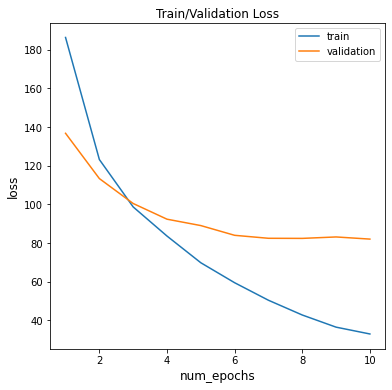

In [59]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.80      0.89      0.84       384
                 displaced_people_and_evacuations       0.92      0.99      0.95       382
donation_needs_or_offers_or_volunteering_services       0.77      0.74      0.75       384
              infrastructure_and_utilities_damage       0.86      0.88      0.87       384
                           injured_or_dead_people       0.91      0.88      0.90       384
                  missing_trapped_or_found_people       0.94      0.97      0.96       384
                        not_related_or_irrelevant       0.65      0.67      0.66       384
                         other_useful_information       0.60      0.52      0.56       384
                   sympathy_and_emotional_support       0.75      0.70      0.73       384

                                         accuracy                           0.80      34

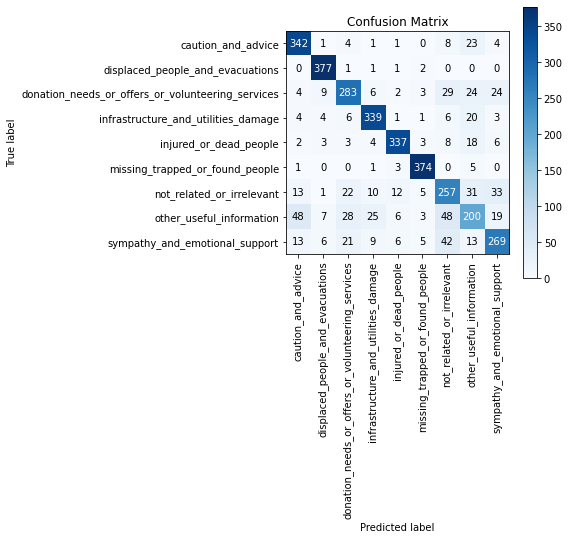

In [60]:
conf_matrix(val_preds)

In [61]:
#Run the model2
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name2)

Epoch 1/10 	 loss=223.9293 	 val_loss=164.9702  	 val_acc=0.5643  	 time=16.74s
Epoch 2/10 	 loss=143.9025 	 val_loss=131.0993  	 val_acc=0.6723  	 time=16.72s
Epoch 3/10 	 loss=115.1016 	 val_loss=118.2054  	 val_acc=0.7030  	 time=16.73s
Epoch 4/10 	 loss=94.2877 	 val_loss=105.3784  	 val_acc=0.7360  	 time=16.71s
Epoch 5/10 	 loss=78.2822 	 val_loss=95.5833  	 val_acc=0.7623  	 time=16.72s
Epoch 6/10 	 loss=64.8658 	 val_loss=96.1026  	 val_acc=0.7710  	 time=16.74s
Epoch 7/10 	 loss=54.0401 	 val_loss=96.2765  	 val_acc=0.7785  	 time=16.73s
Epoch 8/10 	 loss=44.4159 	 val_loss=100.5224  	 val_acc=0.7852  	 time=16.70s
Epoch 9/10 	 loss=38.0910 	 val_loss=99.0494  	 val_acc=0.7820  	 time=16.73s
Epoch 10/10 	 loss=30.8493 	 val_loss=107.8718  	 val_acc=0.7721  	 time=16.73s


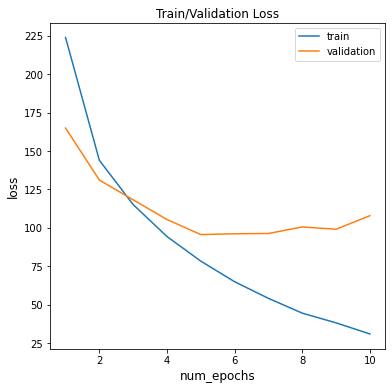

In [62]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.64      0.90      0.75       384
                 displaced_people_and_evacuations       0.93      0.96      0.94       382
donation_needs_or_offers_or_volunteering_services       0.72      0.73      0.72       384
              infrastructure_and_utilities_damage       0.87      0.82      0.85       384
                           injured_or_dead_people       0.86      0.88      0.87       384
                  missing_trapped_or_found_people       0.93      0.96      0.94       384
                        not_related_or_irrelevant       0.71      0.58      0.64       384
                         other_useful_information       0.52      0.42      0.46       384
                   sympathy_and_emotional_support       0.77      0.70      0.73       384

                                         accuracy                           0.77      34

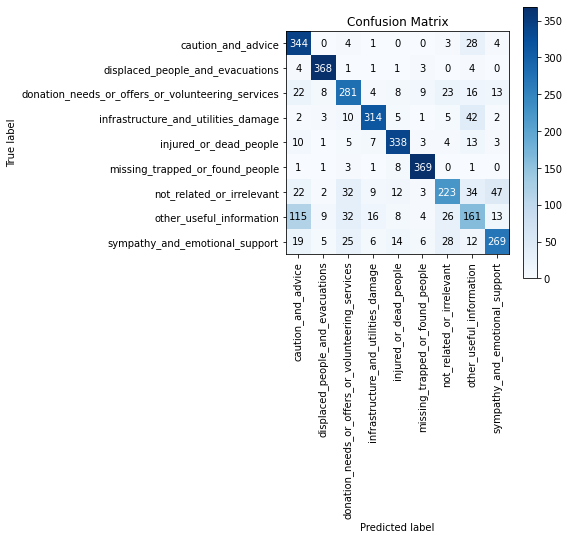

In [63]:
conf_matrix(val_preds)

In [64]:
#Run the model3
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name3)

Epoch 1/10 	 loss=202.6331 	 val_loss=139.6489  	 val_acc=0.6349  	 time=16.58s
Epoch 2/10 	 loss=114.2907 	 val_loss=117.7139  	 val_acc=0.6850  	 time=16.53s
Epoch 3/10 	 loss=84.6048 	 val_loss=94.9985  	 val_acc=0.7701  	 time=16.57s
Epoch 4/10 	 loss=61.6995 	 val_loss=93.7854  	 val_acc=0.7750  	 time=16.52s
Epoch 5/10 	 loss=45.6267 	 val_loss=93.1214  	 val_acc=0.7901  	 time=16.72s
Epoch 6/10 	 loss=33.4665 	 val_loss=112.0166  	 val_acc=0.7577  	 time=16.52s
Epoch 7/10 	 loss=26.3807 	 val_loss=112.5962  	 val_acc=0.7805  	 time=16.54s
Epoch 8/10 	 loss=17.9503 	 val_loss=116.0457  	 val_acc=0.7953  	 time=16.53s
Epoch 9/10 	 loss=13.4006 	 val_loss=128.9539  	 val_acc=0.7814  	 time=16.57s
Epoch 10/10 	 loss=11.8606 	 val_loss=133.0017  	 val_acc=0.7884  	 time=16.51s


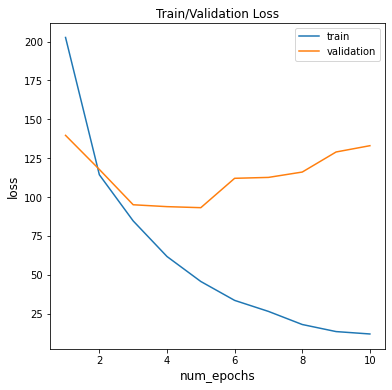

In [65]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.87      0.85      0.86       384
                 displaced_people_and_evacuations       0.92      0.97      0.95       382
donation_needs_or_offers_or_volunteering_services       0.78      0.65      0.71       384
              infrastructure_and_utilities_damage       0.81      0.91      0.86       384
                           injured_or_dead_people       0.91      0.82      0.87       384
                  missing_trapped_or_found_people       0.91      0.97      0.94       384
                        not_related_or_irrelevant       0.60      0.68      0.64       384
                         other_useful_information       0.52      0.59      0.55       384
                   sympathy_and_emotional_support       0.83      0.67      0.74       384

                                         accuracy                           0.79      34

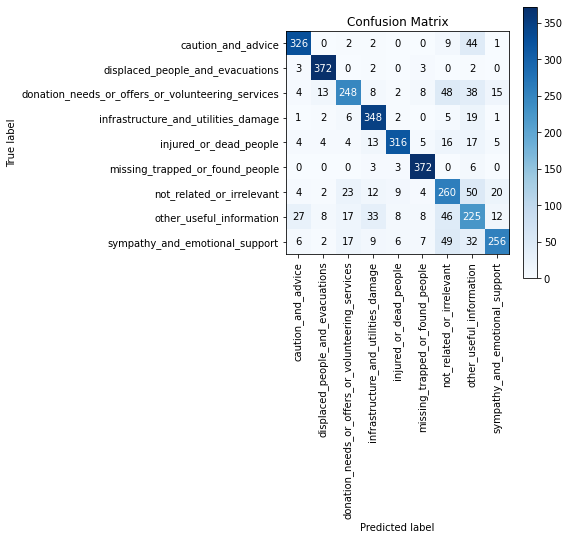

In [66]:
conf_matrix(val_preds)